In [1]:
!pip install pycocoevalcap
!pip install wordfreq

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 104.3/104.3 MB 7.6 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 56.8/56.8 MB 15.9 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 44.8/44.8 kB 4.2 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 183.1/183.1 kB 15.1 MB/s eta 0:00:00


In [2]:

import os
import random
import numpy as np
from PIL import Image
import torch
import torch.nn as nn
from torch.utils.data import Dataset, DataLoader
import torch.nn.functional as F
from pycocoevalcap.bleu.bleu import Bleu
from pycocoevalcap.meteor.meteor import Meteor
from pycocoevalcap.rouge.rouge import Rouge
from pycocoevalcap.cider.cider import Cider
from torchvision import models, transforms
from tqdm import tqdm
from datasets import load_dataset
from typing import List
from collections import Counter
import math

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print("Device:", device)

Device: cuda


In [3]:
class SimpleTokenizer:
    def __init__(self, vocab: List[str]):
        specials = ["<pad>", "<bos>", "<eos>", "<unk>"]
        vocab = specials + [w for w in vocab if w not in specials]
        self.stoi = {w: i for i, w in enumerate(vocab)}
        self.itos = {i: w for w, i in self.stoi.items()}
        self.pad_id = self.stoi["<pad>"]
        self.bos_id = self.stoi["<bos>"]
        self.eos_id = self.stoi["<eos>"]
        self.unk_id = self.stoi["<unk>"]

    def encode(self, text: str) -> List[int]:
        tokens = text.lower().strip().split()
        return [self.stoi.get(t, self.unk_id) for t in tokens]

    def decode(self, ids: List[int]) -> str:
        toks = []
        for i in ids:
            if i in (self.pad_id, self.bos_id, self.eos_id):
                continue
            toks.append(self.itos.get(i, "<unk>"))
        return " ".join(toks)


def collect_rsicd_words(hf_train, hf_val, hf_test, min_freq=3):
    cnt = Counter()
    for split in [hf_train, hf_val, hf_test]:
        for ex in split:
            cap = ex["captions"]
            if isinstance(cap, list):
                for c in cap:
                    cnt.update(c.lower().strip().split())
            else:
                cnt.update(cap.lower().strip().split())
    words = [w for w, freq in cnt.most_common() if freq >= min_freq]
    return words


# Load dataset
ds = load_dataset("arampacha/rsicd")
rsicd_words = collect_rsicd_words(ds["train"], ds["valid"], ds["test"], min_freq=3)
print(f"RSICD unique words (freq >=3): {len(rsicd_words)}")

try:
    from wordfreq import top_n_list
    gigaword_top = top_n_list("en", n=5000)
    merged = list(dict.fromkeys(rsicd_words + gigaword_top))
    print(f"After adding wordfreq top-5k: {len(merged)}")
except:
    print("Wordfreq not available, using RSICD only")
    merged = rsicd_words

tokenizer = SimpleTokenizer(merged)
print(f"Final vocab size: {len(tokenizer.stoi)}")

/usr/local/lib/python3.12/dist-packages/huggingface_hub/utils/_auth.py:94: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(


dataset_infos.json: 0.00B [00:00, ?B/s]

data/train-00000-of-00001.parquet:   0%|          | 0.00/419M [00:00<?, ?B/s]

data/test-00000-of-00001.parquet:   0%|          | 0.00/55.1M [00:00<?, ?B/s]

data/valid-00000-of-00001.parquet:   0%|          | 0.00/51.6M [00:00<?, ?B/s]

Generating train split:   0%|          | 0/8734 [00:00<?, ? examples/s]

Generating test split:   0%|          | 0/1093 [00:00<?, ? examples/s]

Generating valid split:   0%|          | 0/1094 [00:00<?, ? examples/s]

RSICD unique words (freq >=3): 2215
After adding wordfreq top-5k: 6332
Final vocab size: 6336


In [4]:
train_transform = transforms.Compose([
    transforms.Resize((256, 256)),
    transforms.RandomCrop((224, 224)),
    transforms.RandomHorizontalFlip(p=0.5),
    transforms.ColorJitter(0.1, 0.1, 0.1, 0.05),
    transforms.RandomRotation(10),
    transforms.ToTensor(),
    transforms.Normalize(
        mean=[0.485, 0.456, 0.406],
        std=[0.229, 0.224, 0.225]
    ),
])

val_transform = transforms.Compose([
    transforms.Resize((224, 224)),
    transforms.ToTensor(),
    transforms.Normalize(
        mean=[0.485, 0.456, 0.406],
        std=[0.229, 0.224, 0.225]
    ),
])
class RSICDDataset(Dataset):
    def __init__(self, hf_split, tokenizer, transform=None, max_len=25, is_train=True):
        self.data = hf_split
        self.tokenizer = tokenizer
        self.transform = transform
        self.max_len = max_len
        self.is_train = is_train

    def __len__(self):
        return len(self.data)

    def __getitem__(self, idx):
        ex = self.data[idx]

        # Load image
        img_path = ex.get("image_path", ex.get("image"))
        if isinstance(img_path, str):
            image = Image.open(img_path).convert("RGB")
        else:
            image = ex["image"]
            if not isinstance(image, Image.Image):
                image = Image.fromarray(np.array(image))

        if self.transform is not None:
            image = self.transform(image)

        # Random sampling
        caps = ex["captions"]
        if isinstance(caps, str):
            caps = [caps]
        caps = [c.strip() for c in caps if isinstance(c, str) and c.strip()]
        if len(caps) == 0:
            caps = ["empty image"]

        if self.is_train:
            caption = random.choice(caps)
        else:
            caption = caps[0]

        # Encode
        caption_ids = self.tokenizer.encode(caption)
        caption_ids = [self.tokenizer.bos_id] + caption_ids + [self.tokenizer.eos_id]
        caption_ids = caption_ids[:self.max_len]

        pad_len = self.max_len - len(caption_ids)
        if pad_len > 0:
            caption_ids = caption_ids + [self.tokenizer.pad_id] * pad_len

        caption_ids = torch.tensor(caption_ids, dtype=torch.long)

        return image, caption_ids, caps


def collate_fn(batch):
    images = torch.stack([item[0] for item in batch])
    caption_ids = torch.stack([item[1] for item in batch])
    all_captions = [item[2] for item in batch]
    return images, caption_ids, all_captions

In [5]:
batch_size = 64
max_len = 25

train_data = RSICDDataset(ds["train"], tokenizer, transform=train_transform, max_len=max_len, is_train=True)
val_data = RSICDDataset(ds["valid"], tokenizer, transform=val_transform, max_len=max_len, is_train=False)
test_data = RSICDDataset(ds["test"], tokenizer, transform=val_transform, max_len=max_len, is_train=False)

train_loader = DataLoader(train_data, batch_size=batch_size, shuffle=True, num_workers=2, pin_memory=True, collate_fn=collate_fn)
val_loader = DataLoader(val_data, batch_size=batch_size, shuffle=False, num_workers=2, pin_memory=True, collate_fn=collate_fn)
test_loader = DataLoader(test_data, batch_size=batch_size, shuffle=False, num_workers=2, pin_memory=True, collate_fn=collate_fn)

print(f"Train: {len(train_data)}, Val: {len(val_data)}, Test: {len(test_data)}")

Train: 8734, Val: 1094, Test: 1093


In [6]:
class ResNetEncoder(nn.Module):
    def __init__(self, output_dim=512, dropout_p=0.5):
        super().__init__()
        base_model = models.resnet101(weights=models.ResNet101_Weights.IMAGENET1K_V2)

        # Freeze early layers
        for param in list(base_model.parameters())[:-30]:
            param.requires_grad = False

        # Extract features before final pooling (7x7 spatial features)
        modules = list(base_model.children())[:-2]  # Remove avgpool and fc
        self.cnn = nn.Sequential(*modules)
        in_features = 2048  # ResNet101 output channels

        # Project spatial features
        self.spatial_proj = nn.Conv2d(in_features, output_dim, kernel_size=1)

        # Global features
        self.avgpool = nn.AdaptiveAvgPool2d((1, 1))
        self.fc = nn.Linear(in_features, output_dim)
        self.bn = nn.BatchNorm1d(output_dim)
        self.dropout = nn.Dropout(dropout_p)

    def forward(self, x):
        """
        Returns:
            spatial_feats: (B, num_regions, output_dim) - for attention
            global_feats: (B, output_dim) - for initialization
        """
        with torch.set_grad_enabled(self.training):
            feats = self.cnn(x)  # (B, 2048, 7, 7)

        # Spatial features for attention
        spatial = self.spatial_proj(feats)  # (B, output_dim, 7, 7)
        B, C, H, W = spatial.size()
        spatial = spatial.view(B, C, H * W).transpose(1, 2)  # (B, 49, output_dim)

        # Global features
        global_feats = self.avgpool(feats).view(B, -1)  # (B, 2048)
        global_feats = self.fc(global_feats)  # (B, output_dim)
        global_feats = self.bn(global_feats)
        global_feats = self.dropout(global_feats)

        return spatial, global_feats


# ============================================================================
# SPATIAL ATTENTION MECHANISM
# ============================================================================
class SpatialAttention(nn.Module):
    def __init__(self, hidden_dim, feat_dim):
        super().__init__()
        self.hidden_proj = nn.Linear(hidden_dim, feat_dim)
        self.feat_proj = nn.Linear(feat_dim, feat_dim)
        self.attention = nn.Linear(feat_dim, 1)

    def forward(self, hidden, spatial_feats):
        """
        hidden: (B, hidden_dim) - current LSTM hidden state
        spatial_feats: (B, num_regions, feat_dim) - spatial features from encoder

        Returns:
            context: (B, feat_dim) - weighted sum of spatial features
            alpha: (B, num_regions) - attention weights
        """
        # Project hidden state
        h_proj = self.hidden_proj(hidden).unsqueeze(1)  # (B, 1, feat_dim)

        # Project spatial features
        f_proj = self.feat_proj(spatial_feats)  # (B, num_regions, feat_dim)

        # Compute attention scores
        combined = torch.tanh(h_proj + f_proj)  # (B, num_regions, feat_dim)
        scores = self.attention(combined).squeeze(-1)  # (B, num_regions)

        # Attention weights
        alpha = F.softmax(scores, dim=1)  # (B, num_regions)

        # Weighted sum
        context = torch.bmm(alpha.unsqueeze(1), spatial_feats).squeeze(1)  # (B, feat_dim)

        return context, alpha


In [7]:
class AttentionLSTMDecoder(nn.Module):
    def __init__(self, vocab_size, embed_dim=512, hidden_dim=512, feat_dim=512, num_layers=3, dropout_p=0.5):
        super().__init__()
        self.num_layers = num_layers
        self.hidden_dim = hidden_dim

        self.embed = nn.Embedding(vocab_size, embed_dim)
        self.dropout_embed = nn.Dropout(dropout_p)

        # Attention mechanism
        self.attention = SpatialAttention(hidden_dim, feat_dim)

        # LSTM input: word embedding + attended context
        self.lstm = nn.LSTM(
            embed_dim + feat_dim,
            hidden_dim,
            num_layers=num_layers,
            batch_first=True,
            dropout=dropout_p if num_layers > 1 else 0
        )

        self.dropout = nn.Dropout(dropout_p)
        self.fc = nn.Linear(hidden_dim, vocab_size)

        # Initialize weights
        self.embed.weight.data.uniform_(-0.1, 0.1)
        self.fc.bias.data.fill_(0)
        self.fc.weight.data.uniform_(-0.1, 0.1)

    def forward(self, spatial_feats, global_feats, caption_ids):
        """
        spatial_feats: (B, num_regions, feat_dim)
        global_feats: (B, hidden_dim)
        caption_ids: (B, T)
        """
        B, T = caption_ids.size()

        # Initial hidden state from global features
        h = global_feats.unsqueeze(0).repeat(self.num_layers, 1, 1)
        c = torch.zeros_like(h)

        # Embed captions
        embeddings = self.embed(caption_ids)  # (B, T, embed_dim)
        embeddings = self.dropout_embed(embeddings)

        outputs = []
        for t in range(T):
            # Current hidden state (take last layer)
            current_h = h[-1]  # (B, hidden_dim)

            # Attend to spatial features
            context, _ = self.attention(current_h, spatial_feats)  # (B, feat_dim)

            # Concatenate word embedding and context
            lstm_input = torch.cat([embeddings[:, t:t+1, :], context.unsqueeze(1)], dim=2)  # (B, 1, embed+feat)

            # LSTM step
            out, (h, c) = self.lstm(lstm_input, (h, c))
            outputs.append(out)

        outputs = torch.cat(outputs, dim=1)  # (B, T, hidden_dim)
        outputs = self.dropout(outputs)
        logits = self.fc(outputs)  # (B, T, vocab_size)

        return logits

In [8]:
class ImageCaptioningModel(nn.Module):
    def __init__(self, encoder, decoder):
        super().__init__()
        self.encoder = encoder
        self.decoder = decoder

    def forward(self, images, caption_ids):
        spatial_feats, global_feats = self.encoder(images)
        logits = self.decoder(spatial_feats, global_feats, caption_ids[:, :-1])
        return logits

    def sample_caption(self, spatial_feats, global_feats, max_len, start_token_id, end_token_id, pad_id=0, sample=False):
        """
        Sample caption using multinomial sampling (for SCST)

        Returns:
            sequences: (B, max_len) - generated token ids
            log_probs_seq: (B, max_len) - log probabilities of selected tokens
        """
        B = global_feats.size(0)
        device = global_feats.device

        h = global_feats.unsqueeze(0).repeat(self.decoder.num_layers, 1, 1)
        c = torch.zeros_like(h)

        sequences = torch.full((B, max_len), pad_id, dtype=torch.long, device=device)
        sequences[:, 0] = start_token_id

        log_probs_list = []
        current_word = torch.full((B,), start_token_id, dtype=torch.long, device=device)

        # Track which sequences are still active
        active_mask = torch.ones(B, dtype=torch.bool, device=device)

        for t in range(1, max_len):
            current_h = h[-1]
            context, _ = self.decoder.attention(current_h, spatial_feats)

            word_emb = self.decoder.embed(current_word).unsqueeze(1)
            lstm_input = torch.cat([word_emb, context.unsqueeze(1)], dim=2)

            out, (h, c) = self.decoder.lstm(lstm_input, (h, c))
            logits = self.decoder.fc(out.squeeze(1))
            log_probs = F.log_softmax(logits, dim=-1)

            if sample:
                # Temperature sampling for diversity
                temperature = 1.0
                probs = torch.exp(log_probs / temperature)
                next_word = torch.multinomial(probs, 1).squeeze(1)
            else:
                # Greedy decoding
                next_word = log_probs.argmax(dim=-1)

            # Only update active sequences
            sequences[active_mask, t] = next_word[active_mask]

            # Gather log probs for selected tokens
            selected_log_probs = log_probs.gather(1, next_word.unsqueeze(1)).squeeze(1)
            log_probs_list.append(selected_log_probs)

            # Update active mask (sequences that haven't generated <eos>)
            active_mask = active_mask & (next_word != end_token_id)

            # Update current word for next iteration
            current_word = next_word

            # Stop if all sequences finished
            if not active_mask.any():
                break

        # Stack log probs and pad to consistent length (max_len - 1)
        if log_probs_list:
            log_probs_seq = torch.stack(log_probs_list, dim=1)  # (B, T_actual)

            # Pad to match expected length (max_len - 1, because we skip <bos>)
            expected_len = max_len - 1
            current_len = log_probs_seq.size(1)

            if current_len < expected_len:
                pad_size = expected_len - current_len
                log_probs_seq = F.pad(log_probs_seq, (0, pad_size), value=0.0)
        else:
            log_probs_seq = torch.zeros(B, max_len - 1, device=device)

        return sequences, log_probs_seq


    def generate_caption(self, image, start_token_id, end_token_id, max_len=25, beam_size=5, diversity_penalty=0.5):
        """
        Diverse Beam Search with diversity penalty
        """
        self.eval()
        device = image.device

        with torch.no_grad():
            spatial_feats, global_feats = self.encoder(image)

            # Initialize beams with diversity groups
            num_groups = 3  # Number of diversity groups
            beams_per_group = beam_size // num_groups

            all_beams = []

            for group_id in range(num_groups):
                beams = [([start_token_id], 0.0, global_feats.clone(), torch.zeros_like(global_feats))]
                completed = []

                for step in range(max_len):
                    candidates = []

                    for seq, score, h_state, c_state in beams:
                        if seq[-1] == end_token_id:
                            completed.append((seq, score))
                            continue

                        # Get next token probabilities
                        h = h_state.unsqueeze(0).repeat(self.decoder.num_layers, 1, 1)
                        c = c_state.unsqueeze(0).repeat(self.decoder.num_layers, 1, 1)

                        current_h = h[-1]
                        context, _ = self.decoder.attention(current_h, spatial_feats)

                        seq_tensor = torch.tensor([seq[-1]], dtype=torch.long, device=device).unsqueeze(0)
                        word_emb = self.decoder.embed(seq_tensor)
                        lstm_input = torch.cat([word_emb, context.unsqueeze(1)], dim=2)

                        out, (h_new, c_new) = self.decoder.lstm(lstm_input, (h, c))
                        logits = self.decoder.fc(out.squeeze(1))
                        log_probs = F.log_softmax(logits, dim=-1)

                        # Apply diversity penalty for non-first groups
                        if group_id > 0:
                            for prev_group_beams in all_beams[:group_id]:
                                for prev_seq, _ in prev_group_beams[:5]:
                                    if len(prev_seq) > len(seq):
                                        prev_token = prev_seq[len(seq)]
                                        log_probs[0, prev_token] -= diversity_penalty

                        topk_log_probs, topk_ids = torch.topk(log_probs, beams_per_group)

                        for i in range(beams_per_group):
                            token_id = topk_ids[0, i].item()
                            token_score = topk_log_probs[0, i].item()
                            new_seq = seq + [token_id]
                            new_score = score + token_score
                            candidates.append((new_seq, new_score, h_new[-1].squeeze(0), c_new[-1].squeeze(0)))

                    if not candidates:
                        break

                    candidates.sort(key=lambda x: x[1], reverse=True)
                    beams = candidates[:beams_per_group]

                if not completed:
                    completed = [(b[0], b[1]) for b in beams]

                all_beams.append(completed)

            # Select best from all groups
            all_completed = [item for group in all_beams for item in group]
            all_completed.sort(key=lambda x: x[1] / len(x[0]), reverse=True)
            best_seq = all_completed[0][0]

            return best_seq


In [9]:
vocab_size = len(tokenizer.stoi)
embed_dim = 512
hidden_dim = 512
feat_dim = 512

encoder = ResNetEncoder(output_dim=feat_dim, dropout_p=0.5)
decoder = AttentionLSTMDecoder(vocab_size, embed_dim, hidden_dim, feat_dim, num_layers=1, dropout_p=0.5)
model = ImageCaptioningModel(encoder, decoder).to(device)

print(f"Model parameters: {sum(p.numel() for p in model.parameters() if p.requires_grad):,}")

Downloading: "https://download.pytorch.org/models/resnet101-cd907fc2.pth" to /root/.cache/torch/hub/checkpoints/resnet101-cd907fc2.pth


100%|██████████| 171M/171M [00:01<00:00, 162MB/s]


Model parameters: 26,709,185


In [10]:
class LabelSmoothingLoss(nn.Module):
    def __init__(self, vocab_size, padding_idx, smoothing=0.1):
        super().__init__()
        self.vocab_size = vocab_size
        self.padding_idx = padding_idx
        self.confidence = 1.0 - smoothing
        self.smoothing = smoothing

    def forward(self, pred, target):
        """
        pred: (B*T, vocab_size) - log probabilities
        target: (B*T,) - ground truth
        """
        pred = pred.log_softmax(dim=-1)
        with torch.no_grad():
            true_dist = torch.zeros_like(pred)
            true_dist.fill_(self.smoothing / (self.vocab_size - 2))  # -2 for pad and true class
            true_dist.scatter_(1, target.unsqueeze(1), self.confidence)
            true_dist[:, self.padding_idx] = 0
            mask = (target == self.padding_idx)
            true_dist[mask] = 0

        loss = -(true_dist * pred).sum(dim=-1)
        loss = loss.masked_fill(mask, 0).sum() / (mask == 0).sum()
        return loss


criterion = LabelSmoothingLoss(vocab_size, tokenizer.pad_id, smoothing=0.1)
# Separate learning rates
optimizer = torch.optim.AdamW([
    {'params': encoder.parameters(), 'lr': 1e-5},  # encoder lr thấp hơn
    {'params': decoder.parameters(), 'lr': 5e-4}   # decoder lr cao hơn
], weight_decay=1e-4)
num_epochs = 30

# Cosine annealing scheduler
scheduler = torch.optim.lr_scheduler.CosineAnnealingLR(optimizer, T_max=num_epochs, eta_min=1e-6)

In [11]:
def train_one_epoch_xe(model, loader, optimizer, criterion, device, scheduled_sampling_prob=0.0):
    """Cross-entropy training with scheduled sampling"""
    model.train()
    total_loss = 0.0

    for images, caption_ids, _ in tqdm(loader, desc="Train (XE)", leave=False):
        images = images.to(device)
        caption_ids = caption_ids.to(device)
        B, T = caption_ids.size()

        spatial_feats, global_feats = model.encoder(images)

        # Teacher forcing with scheduled sampling
        if scheduled_sampling_prob > 0 and random.random() < scheduled_sampling_prob:
            # Use model's own predictions sometimes
            logits = []
            h = global_feats.unsqueeze(0).repeat(model.decoder.num_layers, 1, 1)
            c = torch.zeros_like(h)

            input_token = caption_ids[:, 0]
            for t in range(T - 1):
                current_h = h[-1]
                context, _ = model.decoder.attention(current_h, spatial_feats)
                word_emb = model.decoder.embed(input_token).unsqueeze(1)
                lstm_input = torch.cat([word_emb, context.unsqueeze(1)], dim=2)
                out, (h, c) = model.decoder.lstm(lstm_input, (h, c))
                out = model.decoder.dropout(out)
                logit = model.decoder.fc(out.squeeze(1))
                logits.append(logit.unsqueeze(1))

                # Sample from model or use ground truth
                if random.random() < 0.5:
                    input_token = logit.argmax(dim=-1)
                else:
                    input_token = caption_ids[:, t + 1]

            logits = torch.cat(logits, dim=1)
        else:
            # Standard teacher forcing
            logits = model(images, caption_ids)

        target = caption_ids[:, 1:]
        loss = criterion(logits.reshape(-1, vocab_size), target.reshape(-1))

        optimizer.zero_grad()
        loss.backward()
        torch.nn.utils.clip_grad_norm_(model.parameters(), 5.0)
        optimizer.step()

        total_loss += loss.item()

    return total_loss / len(loader)


def compute_cider_score(refs, hyps, return_per_sample=False):
    """Helper to compute CIDEr score"""
    cider_scorer = Cider()
    score, scores = cider_scorer.compute_score(refs, hyps)
    if return_per_sample:
        return scores  # list điểm cho từng sample
    else:
        return score


def train_one_epoch_scst(model, loader, tokenizer, optimizer, device, baseline_type='greedy'):
    model.train()
    total_loss, total_reward, num_batches = 0.0, 0.0, 0

    for images, caption_ids, all_caps_batch in tqdm(loader, desc="Train (SCST)", leave=False):
        images = images.to(device)
        B = images.size(0)

        spatial_feats, global_feats = model.encoder(images)

        # Sample captions
        sampled_seqs, sampled_log_probs = model.sample_caption(
            spatial_feats, global_feats,
            max_len=25,
            start_token_id=tokenizer.bos_id,
            end_token_id=tokenizer.eos_id,
            pad_id=tokenizer.pad_id,
            sample=True
        )

        # Baseline (greedy)
        with torch.no_grad():
            baseline_seqs, _ = model.sample_caption(
                spatial_feats, global_feats,
                max_len=25,
                start_token_id=tokenizer.bos_id,
                end_token_id=tokenizer.eos_id,
                pad_id=tokenizer.pad_id,
                sample=False
            )

        # Decode captions
        refs_batch, sampled_batch, baseline_batch = {}, {}, {}
        valid_indices = []
        for i in range(B):
            sampled_text = tokenizer.decode(sampled_seqs[i].tolist()).strip()
            baseline_text = tokenizer.decode(baseline_seqs[i].tolist()).strip()
            if not sampled_text or not baseline_text:
                continue
            refs_batch[i] = all_caps_batch[i]
            sampled_batch[i] = [sampled_text]
            baseline_batch[i] = [baseline_text]
            valid_indices.append(i)

        if len(valid_indices) == 0:
            continue

        # Tính CIDEr per-sample bằng helper
        sampled_scores = compute_cider_score(refs_batch, sampled_batch, return_per_sample=True)
        baseline_scores = compute_cider_score(refs_batch, baseline_batch, return_per_sample=True)

        rewards = torch.tensor(
            [s - b for s, b in zip(sampled_scores, baseline_scores)],
            device=device, dtype=torch.float32
        )

        # Lấy log_probs và seq tương ứng
        valid_log_probs = sampled_log_probs[valid_indices]
        valid_seqs = sampled_seqs[valid_indices]
        mask = (valid_seqs != tokenizer.pad_id).float()

        log_probs_sum = (valid_log_probs * mask[:, 1:]).sum(dim=1)
        seq_lengths = mask[:, 1:].sum(dim=1)
        normalized_log_probs = log_probs_sum / (seq_lengths + 1e-8)

        # Loss SCST
        loss = -(normalized_log_probs * rewards).mean()

        optimizer.zero_grad()
        loss.backward()
        torch.nn.utils.clip_grad_norm_(model.parameters(), 5.0)
        optimizer.step()

        total_loss += loss.item()
        total_reward += rewards.mean().item()
        num_batches += 1

    avg_loss = total_loss / max(num_batches, 1)
    avg_reward = total_reward / max(num_batches, 1)
    return avg_loss, avg_reward


def evaluate(model, loader, tokenizer, device, max_samples=None):
    """Quick evaluation for validation"""
    model.eval()
    total_loss = 0.0
    refs = {}
    hyps = {}
    idx = 0

    with torch.no_grad():
        for images, caption_ids, all_caps_batch in tqdm(loader, desc="Eval", leave=False):
            images = images.to(device)
            caption_ids = caption_ids.to(device)

            logits = model(images, caption_ids)
            target = caption_ids[:, 1:]
            loss = criterion(logits.reshape(-1, vocab_size), target.reshape(-1))
            total_loss += loss.item()

            for i in range(images.size(0)):
                if max_samples and idx >= max_samples:
                    break

                img = images[i].unsqueeze(0)
                token_ids = model.generate_caption(
                    img,
                    tokenizer.bos_id,
                    tokenizer.eos_id,
                    max_len=25,
                    beam_size=5,
                    diversity_penalty=0.3
                )

                hyp = tokenizer.decode(token_ids)
                refs[idx] = all_caps_batch[i]
                hyps[idx] = [hyp]
                idx += 1

            if max_samples and idx >= max_samples:
                break

    avg_loss = total_loss / len(loader)

    bleu_scorer = Bleu(4)
    bleu_scores, _ = bleu_scorer.compute_score(refs, hyps)

    cider_scorer = Cider()
    cider_score, _ = cider_scorer.compute_score(refs, hyps)

    return avg_loss, bleu_scores[3], cider_score


def test_evaluation(model, loader, tokenizer, device):
    """Comprehensive test evaluation"""
    model.eval()
    total_loss = 0.0
    refs = {}
    hyps = {}
    idx = 0

    print("Generating captions for test set...")
    with torch.no_grad():
        for images, caption_ids, all_caps_batch in tqdm(loader, desc="Test"):
            images = images.to(device)
            caption_ids = caption_ids.to(device)

            logits = model(images, caption_ids)
            target = caption_ids[:, 1:]
            loss = criterion(logits.reshape(-1, vocab_size), target.reshape(-1))
            total_loss += loss.item()

            for i in range(images.size(0)):
                img = images[i].unsqueeze(0)
                token_ids = model.generate_caption(
                    img,
                    tokenizer.bos_id,
                    tokenizer.eos_id,
                    max_len=25,
                    beam_size=5,
                    diversity_penalty=0.3
                )

                hyp = tokenizer.decode(token_ids)
                refs[idx] = all_caps_batch[i]
                hyps[idx] = [hyp]
                idx += 1

    avg_loss = total_loss / len(loader)

    print("\nComputing metrics...")
    results = {'loss': avg_loss, 'num_samples': idx}

    print("  - Computing BLEU scores...")
    bleu_scorer = Bleu(4)
    bleu_scores, _ = bleu_scorer.compute_score(refs, hyps)
    results['BLEU_1'] = bleu_scores[0]
    results['BLEU_2'] = bleu_scores[1]
    results['BLEU_3'] = bleu_scores[2]
    results['BLEU_4'] = bleu_scores[3]

    print("  - Computing METEOR...")
    meteor_scorer = Meteor()
    meteor_score, _ = meteor_scorer.compute_score(refs, hyps)
    results['METEOR'] = meteor_score

    print("  - Computing ROUGE-L...")
    rouge_scorer = Rouge()
    rouge_score, _ = rouge_scorer.compute_score(refs, hyps)
    results['ROUGE_L'] = rouge_score

    print("  - Computing CIDEr...")
    cider_scorer = Cider()
    cider_score, _ = cider_scorer.compute_score(refs, hyps)
    results['CIDEr'] = cider_score

    try:
        print("  - Computing SPICE...")
        from pycocoevalcap.spice.spice import Spice
        spice_scorer = Spice()
        spice_score, _ = spice_scorer.compute_score(refs, hyps)
        results['SPICE'] = spice_score
    except Exception as e:
        print(f"  - SPICE not available: {e}")
        results['SPICE'] = None

    return results, refs, hyps

In [12]:
import matplotlib.pyplot as plt

def plot_loss_curve(train_losses, val_losses):
    epochs = range(1, len(train_losses) + 1)

    plt.figure()
    plt.plot(epochs, train_losses, label="Train Loss")
    plt.plot(epochs, val_losses, label="Val Loss")
    plt.xlabel("Epoch")
    plt.ylabel("Loss")
    plt.title("Training & Validation Loss")
    plt.legend()
    plt.grid(True)
    plt.show()
def plot_cider_curve(ciders):
    epochs = range(1, len(ciders) + 1)

    plt.figure()
    plt.plot(epochs, ciders, label="CIDEr")
    plt.xlabel("Epoch")
    plt.ylabel("CIDEr")
    plt.title("Validation CIDEr")
    plt.legend()
    plt.grid(True)
    plt.show()


{'testlen': 14465, 'reflen': 11807, 'guess': [14465, 13371, 12277, 11183], 'correct': [6914, 2603, 1260, 451]}
ratio: 1.2251206911153363
Epoch 1/30
  Train Loss: 5.2341, SS Prob: 0.00
  Val Loss: 4.7602, BLEU-4: 14.01, CIDEr: 0.2654
  LR: 1.00e-05
Saved best XE model (CIDEr: 0.2654)


{'testlen': 12533, 'reflen': 11259, 'guess': [12533, 11439, 10345, 9251], 'correct': [7017, 3306, 1808, 968]}
ratio: 1.1131539213072996
Epoch 2/30
  Train Loss: 3.7038, SS Prob: 0.01
  Val Loss: 4.2242, BLEU-4: 23.32, CIDEr: 0.7031
  LR: 9.98e-06
Saved best XE model (CIDEr: 0.7031)


{'testlen': 12152, 'reflen': 11163, 'guess': [12152, 11058, 9964, 8870], 'correct': [7259, 3670, 2092, 1216]}
ratio: 1.0885962554867787
Epoch 3/30
  Train Loss: 3.3557, SS Prob: 0.02
  Val Loss: 4.0286, BLEU-4: 27.48, CIDEr: 0.9022
  LR: 9.90e-06
Saved best XE model (CIDEr: 0.9022)


{'testlen': 12699, 'reflen': 11306, 'guess': [12699, 11605, 10511, 9417], 'correct': [7612, 4054, 2411, 1472]}
ratio: 1.1232089156199254
Epoch 4/30
  Train Loss: 3.1521, SS Prob: 0.03
  Val Loss: 3.9313, BLEU-4: 29.44, CIDEr: 1.0695
  LR: 9.78e-06
Saved best XE model (CIDEr: 1.0695)


{'testlen': 12150, 'reflen': 11198, 'guess': [12150, 11056, 9962, 8868], 'correct': [7598, 4162, 2509, 1536]}
ratio: 1.0850151812822748
Epoch 5/30
  Train Loss: 3.0531, SS Prob: 0.03
  Val Loss: 3.8516, BLEU-4: 31.83, CIDEr: 1.1864
  LR: 9.61e-06
Saved best XE model (CIDEr: 1.1864)


{'testlen': 12156, 'reflen': 11205, 'guess': [12156, 11062, 9968, 8874], 'correct': [7730, 4354, 2686, 1693]}
ratio: 1.0848728246317638
Epoch 6/30
  Train Loss: 2.9942, SS Prob: 0.04
  Val Loss: 3.8115, BLEU-4: 33.68, CIDEr: 1.2232
  LR: 9.40e-06
Saved best XE model (CIDEr: 1.2232)


{'testlen': 11803, 'reflen': 11165, 'guess': [11803, 10709, 9615, 8521], 'correct': [7560, 4407, 2797, 1781]}
ratio: 1.0571428571427623
Epoch 7/30
  Train Loss: 2.9422, SS Prob: 0.05
  Val Loss: 3.7673, BLEU-4: 35.58, CIDEr: 1.3431
  LR: 9.14e-06
Saved best XE model (CIDEr: 1.3431)


{'testlen': 12093, 'reflen': 11248, 'guess': [12093, 10999, 9905, 8811], 'correct': [7878, 4565, 2870, 1873]}
ratio: 1.0751244665717394
Epoch 8/30
  Train Loss: 2.9213, SS Prob: 0.06
  Val Loss: 3.7265, BLEU-4: 35.92, CIDEr: 1.4035
  LR: 8.84e-06
Saved best XE model (CIDEr: 1.4035)


{'testlen': 11532, 'reflen': 10955, 'guess': [11532, 10438, 9344, 8250], 'correct': [7713, 4586, 2924, 1869]}
ratio: 1.0526700136922817
Epoch 9/30
  Train Loss: 2.8678, SS Prob: 0.07
  Val Loss: 3.7030, BLEU-4: 37.99, CIDEr: 1.4118
  LR: 8.51e-06
Saved best XE model (CIDEr: 1.4118)


{'testlen': 11863, 'reflen': 11154, 'guess': [11863, 10769, 9675, 8581], 'correct': [7871, 4577, 2896, 1833]}
ratio: 1.063564640487622
Epoch 10/30
  Train Loss: 2.8879, SS Prob: 0.07
  Val Loss: 3.6978, BLEU-4: 36.64, CIDEr: 1.4262
  LR: 8.15e-06
Saved best XE model (CIDEr: 1.4262)


{'testlen': 11687, 'reflen': 11011, 'guess': [11687, 10593, 9499, 8405], 'correct': [7600, 4549, 2907, 1848]}
ratio: 1.0613931523021467
Epoch 11/30
  Train Loss: 2.8443, SS Prob: 0.08
  Val Loss: 3.6806, BLEU-4: 37.02, CIDEr: 1.4005
  LR: 7.75e-06


{'testlen': 11867, 'reflen': 11099, 'guess': [11867, 10773, 9679, 8585], 'correct': [7772, 4588, 2912, 1859]}
ratio: 1.0691954230109857
Epoch 12/30
  Train Loss: 2.8749, SS Prob: 0.09
  Val Loss: 3.6835, BLEU-4: 36.72, CIDEr: 1.4747
  LR: 7.33e-06
Saved best XE model (CIDEr: 1.4747)


{'testlen': 12092, 'reflen': 11211, 'guess': [12092, 10998, 9904, 8810], 'correct': [8025, 4798, 3053, 1975]}
ratio: 1.0785835340289824
Epoch 13/30
  Train Loss: 2.8367, SS Prob: 0.10
  Val Loss: 3.6602, BLEU-4: 37.61, CIDEr: 1.4822
  LR: 6.89e-06
Saved best XE model (CIDEr: 1.4822)


{'testlen': 11698, 'reflen': 11025, 'guess': [11698, 10604, 9510, 8416], 'correct': [7910, 4759, 3102, 2022]}
ratio: 1.0610430839001306
Epoch 14/30
  Train Loss: 2.7994, SS Prob: 0.11
  Val Loss: 3.6379, BLEU-4: 39.27, CIDEr: 1.5590
  LR: 6.44e-06
Saved best XE model (CIDEr: 1.5590)


{'testlen': 11577, 'reflen': 10956, 'guess': [11577, 10483, 9389, 8295], 'correct': [7841, 4737, 3029, 1945]}
ratio: 1.0566812705365958
Epoch 15/30
  Train Loss: 2.7341, SS Prob: 0.12
  Val Loss: 3.6336, BLEU-4: 39.01, CIDEr: 1.5285
  LR: 5.97e-06


{'testlen': 11599, 'reflen': 10991, 'guess': [11599, 10505, 9411, 8317], 'correct': [7837, 4692, 3016, 1921]}
ratio: 1.0553179874441765
Epoch 16/30
  Train Loss: 2.7366, SS Prob: 0.12
  Val Loss: 3.6421, BLEU-4: 38.66, CIDEr: 1.4998
  LR: 5.50e-06


{'testlen': 11764, 'reflen': 11069, 'guess': [11764, 10670, 9576, 8482], 'correct': [7966, 4776, 3082, 1999]}
ratio: 1.062787966392532
Epoch 17/30
  Train Loss: 2.7554, SS Prob: 0.13
  Val Loss: 3.6174, BLEU-4: 38.94, CIDEr: 1.4927
  LR: 5.03e-06


{'testlen': 11744, 'reflen': 11092, 'guess': [11744, 10650, 9556, 8462], 'correct': [7883, 4737, 3077, 1971]}
ratio: 1.058781103497921
Epoch 18/30
  Train Loss: 2.7970, SS Prob: 0.14
  Val Loss: 3.6129, BLEU-4: 38.68, CIDEr: 1.5275
  LR: 4.56e-06


{'testlen': 11675, 'reflen': 11065, 'guess': [11675, 10581, 9487, 8393], 'correct': [7898, 4746, 3065, 1981]}
ratio: 1.055128784455395
Epoch 19/30
  Train Loss: 2.7660, SS Prob: 0.15
  Val Loss: 3.6100, BLEU-4: 39.00, CIDEr: 1.5431
  LR: 4.11e-06


{'testlen': 11811, 'reflen': 11104, 'guess': [11811, 10717, 9623, 8529], 'correct': [8038, 4835, 3128, 2032]}
ratio: 1.063670749279443
Epoch 20/30
  Train Loss: 2.7328, SS Prob: 0.16
  Val Loss: 3.6065, BLEU-4: 39.27, CIDEr: 1.5603
  LR: 3.67e-06
Saved best XE model (CIDEr: 1.5603)


{'testlen': 11840, 'reflen': 11146, 'guess': [11840, 10746, 9652, 8558], 'correct': [8123, 4933, 3226, 2122]}
ratio: 1.0622644895028654
Epoch 21/30
  Train Loss: 2.7203, SS Prob: 0.17
  Val Loss: 3.6082, BLEU-4: 40.19, CIDEr: 1.5834
  LR: 3.25e-06
Saved best XE model (CIDEr: 1.5834)


{'testlen': 11520, 'reflen': 10964, 'guess': [11520, 10426, 9332, 8238], 'correct': [7905, 4821, 3164, 2087]}
ratio: 1.0507114191899807
Epoch 22/30
  Train Loss: 2.7527, SS Prob: 0.17
  Val Loss: 3.5979, BLEU-4: 40.63, CIDEr: 1.5937
  LR: 2.85e-06
Saved best XE model (CIDEr: 1.5937)


{'testlen': 11824, 'reflen': 11156, 'guess': [11824, 10730, 9636, 8542], 'correct': [8077, 4848, 3150, 2062]}
ratio: 1.0598780925061797
Epoch 23/30
  Train Loss: 2.6985, SS Prob: 0.18
  Val Loss: 3.5993, BLEU-4: 39.50, CIDEr: 1.5877
  LR: 2.49e-06


{'testlen': 11641, 'reflen': 11029, 'guess': [11641, 10547, 9453, 8359], 'correct': [7945, 4817, 3131, 2043]}
ratio: 1.055490071629245
Epoch 24/30
  Train Loss: 2.7376, SS Prob: 0.19
  Val Loss: 3.6023, BLEU-4: 39.86, CIDEr: 1.5907
  LR: 2.16e-06


{'testlen': 11663, 'reflen': 11046, 'guess': [11663, 10569, 9475, 8381], 'correct': [7951, 4798, 3078, 1989]}
ratio: 1.0558573239180649
Epoch 25/30
  Train Loss: 2.7374, SS Prob: 0.20
  Val Loss: 3.5933, BLEU-4: 39.30, CIDEr: 1.5681
  LR: 1.86e-06


{'testlen': 11739, 'reflen': 11082, 'guess': [11739, 10645, 9551, 8457], 'correct': [8082, 4943, 3229, 2117]}
ratio: 1.059285327558107
Epoch 26/30
  Train Loss: 2.7320, SS Prob: 0.21
  Val Loss: 3.6002, BLEU-4: 40.56, CIDEr: 1.6083
  LR: 1.60e-06
Saved best XE model (CIDEr: 1.6083)


{'testlen': 11690, 'reflen': 11047, 'guess': [11690, 10596, 9502, 8408], 'correct': [8027, 4881, 3176, 2067]}
ratio: 1.0582058477413725
Epoch 27/30
  Train Loss: 2.7812, SS Prob: 0.22
  Val Loss: 3.5968, BLEU-4: 40.15, CIDEr: 1.5938
  LR: 1.39e-06


{'testlen': 11757, 'reflen': 11085, 'guess': [11757, 10663, 9569, 8475], 'correct': [8018, 4873, 3174, 2069]}
ratio: 1.060622462787455
Epoch 28/30
  Train Loss: 2.8099, SS Prob: 0.23
  Val Loss: 3.5933, BLEU-4: 39.86, CIDEr: 1.6060
  LR: 1.22e-06


{'testlen': 11660, 'reflen': 11035, 'guess': [11660, 10566, 9472, 8378], 'correct': [7961, 4829, 3142, 2052]}
ratio: 1.056637970095056
Epoch 29/30
  Train Loss: 2.8020, SS Prob: 0.23
  Val Loss: 3.5971, BLEU-4: 39.90, CIDEr: 1.5682
  LR: 1.10e-06


{'testlen': 11686, 'reflen': 11096, 'guess': [11686, 10592, 9498, 8404], 'correct': [8031, 4854, 3157, 2060]}
ratio: 1.0531723143474176
Epoch 30/30
  Train Loss: 2.7601, SS Prob: 0.24
  Val Loss: 3.5953, BLEU-4: 40.02, CIDEr: 1.5942
  LR: 1.02e-06


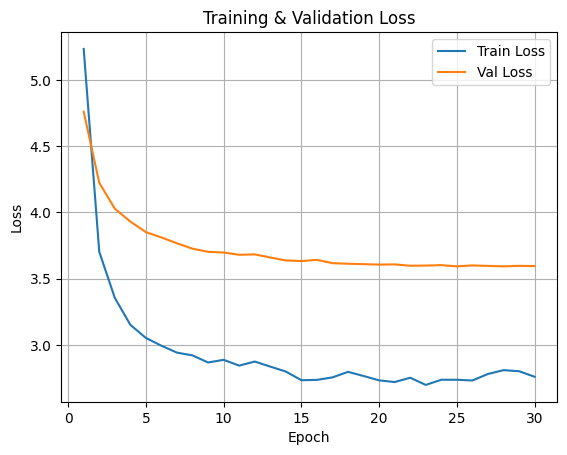

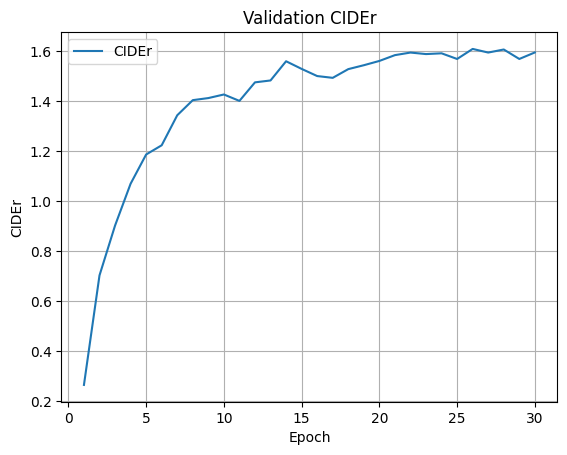

In [13]:
num_epochs_xe = 30
patience = 7
best_cider = 0.0
save_path_xe = "captioner_rsicd_xe.pt"
epochs_no_improve = 0
train_losses = []
val_losses = []
ciders = []
for epoch in range(num_epochs_xe):
    ss_prob = min(0.25, epoch / num_epochs_xe * 0.25)

    train_loss = train_one_epoch_xe(model, train_loader, optimizer, criterion, device, scheduled_sampling_prob=ss_prob)
    val_loss, bleu4, cider = evaluate(model, val_loader, tokenizer, device)
    train_losses.append(train_loss)
    val_losses.append(val_loss)
    ciders.append(cider)
    print(f"Epoch {epoch+1}/{num_epochs_xe}")
    print(f"  Train Loss: {train_loss:.4f}, SS Prob: {ss_prob:.2f}")
    print(f"  Val Loss: {val_loss:.4f}, BLEU-4: {bleu4*100:.2f}, CIDEr: {cider:.4f}")
    print(f"  LR: {optimizer.param_groups[0]['lr']:.2e}")

    scheduler.step()

    if cider > best_cider:
        best_cider = cider
        torch.save({
            'epoch': epoch,
            'model_state_dict': model.state_dict(),
            'optimizer_state_dict': optimizer.state_dict(),
            'cider': cider,
            'bleu4': bleu4,
        }, save_path_xe)
        print(f"Saved best XE model (CIDEr: {cider:.4f})")
        epochs_no_improve = 0
    else:
        epochs_no_improve += 1
        if epochs_no_improve >= patience:
            print("Early stopping triggered")
            break
plot_loss_curve(train_losses, val_losses)
plot_cider_curve(ciders)

Loaded XE model from epoch 26, CIDEr: 1.6083


{'testlen': 14023, 'reflen': 11803, 'guess': [14023, 12929, 11835, 10741], 'correct': [8370, 4910, 3013, 1875]}
ratio: 1.1880877742945701
Epoch 1/20
  Train Loss: -3.9557, Avg Reward: -1.1618
  Val Loss: 3.8847, BLEU-4: 31.68, CIDEr: 1.3045


{'testlen': 13401, 'reflen': 11792, 'guess': [13401, 12307, 11213, 10119], 'correct': [8454, 4961, 3148, 2060]}
ratio: 1.136448439619985
Epoch 2/20
  Train Loss: -2.3021, Avg Reward: -0.8734
  Val Loss: 4.0131, BLEU-4: 34.72, CIDEr: 1.4453


{'testlen': 13054, 'reflen': 11658, 'guess': [13054, 11960, 10866, 9772], 'correct': [8509, 4980, 3171, 2037]}
ratio: 1.1197460971006072
Epoch 3/20
  Train Loss: -1.1422, Avg Reward: -0.5886
  Val Loss: 4.1797, BLEU-4: 35.85, CIDEr: 1.5197


{'testlen': 13275, 'reflen': 11761, 'guess': [13275, 12181, 11087, 9993], 'correct': [8482, 4903, 3074, 1991]}
ratio: 1.1287305501231928
Epoch 4/20
  Train Loss: -0.7423, Avg Reward: -0.4565
  Val Loss: 4.3036, BLEU-4: 34.52, CIDEr: 1.5039


{'testlen': 12906, 'reflen': 11652, 'guess': [12906, 11812, 10718, 9624], 'correct': [8474, 5036, 3222, 2097]}
ratio: 1.1076210092687
Epoch 5/20
  Train Loss: -0.5552, Avg Reward: -0.3958
  Val Loss: 4.3363, BLEU-4: 36.80, CIDEr: 1.5835


{'testlen': 13039, 'reflen': 11659, 'guess': [13039, 11945, 10851, 9757], 'correct': [8549, 5086, 3249, 2084]}
ratio: 1.118363496011569
Epoch 6/20
  Train Loss: -0.4420, Avg Reward: -0.3565
  Val Loss: 4.4913, BLEU-4: 36.55, CIDEr: 1.5635


{'testlen': 12623, 'reflen': 11441, 'guess': [12623, 11529, 10435, 9341], 'correct': [8431, 5055, 3217, 2018]}
ratio: 1.1033126474957518
Epoch 7/20
  Train Loss: -0.3644, Avg Reward: -0.3100
  Val Loss: 4.5698, BLEU-4: 37.37, CIDEr: 1.5753


{'testlen': 12908, 'reflen': 11530, 'guess': [12908, 11814, 10720, 9626], 'correct': [8602, 5138, 3239, 2026]}
ratio: 1.1195143104942653
Epoch 8/20
  Train Loss: -0.3063, Avg Reward: -0.2765
  Val Loss: 4.6219, BLEU-4: 36.85, CIDEr: 1.5642


{'testlen': 12222, 'reflen': 11267, 'guess': [12222, 11128, 10034, 8940], 'correct': [8333, 4976, 3180, 2013]}
ratio: 1.0847608058932205
Epoch 9/20
  Train Loss: -0.2910, Avg Reward: -0.2840
  Val Loss: 4.6142, BLEU-4: 38.41, CIDEr: 1.6152
  Saved best SCST model (CIDEr: 1.6152)


{'testlen': 12742, 'reflen': 11397, 'guess': [12742, 11648, 10554, 9460], 'correct': [8584, 5131, 3293, 2087]}
ratio: 1.1180135123277075
Epoch 10/20
  Train Loss: -0.2501, Avg Reward: -0.2364
  Val Loss: 4.6602, BLEU-4: 37.81, CIDEr: 1.6151


{'testlen': 11987, 'reflen': 11192, 'guess': [11987, 10893, 9799, 8705], 'correct': [8291, 4963, 3183, 2000]}
ratio: 1.071032880628925
Epoch 11/20
  Train Loss: -0.2260, Avg Reward: -0.2168
  Val Loss: 4.6605, BLEU-4: 39.16, CIDEr: 1.6623
  Saved best SCST model (CIDEr: 1.6623)


{'testlen': 12195, 'reflen': 11271, 'guess': [12195, 11101, 10007, 8913], 'correct': [8507, 5076, 3262, 2054]}
ratio: 1.0819803034334945
Epoch 12/20
  Train Loss: -0.2192, Avg Reward: -0.2236
  Val Loss: 4.7927, BLEU-4: 39.34, CIDEr: 1.6884
  Saved best SCST model (CIDEr: 1.6884)


{'testlen': 12612, 'reflen': 11423, 'guess': [12612, 11518, 10424, 9330], 'correct': [8594, 5115, 3242, 2050]}
ratio: 1.1040882430183747
Epoch 13/20
  Train Loss: -0.1906, Avg Reward: -0.2149
  Val Loss: 4.8467, BLEU-4: 37.92, CIDEr: 1.6526


{'testlen': 11949, 'reflen': 11159, 'guess': [11949, 10855, 9761, 8667], 'correct': [8360, 4987, 3198, 2046]}
ratio: 1.0707948740925646
Epoch 14/20
  Train Loss: -0.1819, Avg Reward: -0.2084
  Val Loss: 4.8083, BLEU-4: 39.71, CIDEr: 1.7148
  Saved best SCST model (CIDEr: 1.7148)


{'testlen': 11924, 'reflen': 11131, 'guess': [11924, 10830, 9736, 8642], 'correct': [8333, 5053, 3300, 2090]}
ratio: 1.0712424759679209
Epoch 15/20
  Train Loss: -0.1659, Avg Reward: -0.1939
  Val Loss: 4.8917, BLEU-4: 40.43, CIDEr: 1.7409
  Saved best SCST model (CIDEr: 1.7409)


{'testlen': 11821, 'reflen': 11073, 'guess': [11821, 10727, 9633, 8539], 'correct': [8375, 5042, 3253, 2034]}
ratio: 1.0675517023389265
Epoch 16/20
  Train Loss: -0.1607, Avg Reward: -0.1796
  Val Loss: 4.8658, BLEU-4: 40.46, CIDEr: 1.7118


{'testlen': 12324, 'reflen': 11306, 'guess': [12324, 11230, 10136, 9042], 'correct': [8663, 5211, 3350, 2106]}
ratio: 1.0900406863611276
Epoch 17/20
  Train Loss: -0.1498, Avg Reward: -0.1712
  Val Loss: 4.9883, BLEU-4: 39.81, CIDEr: 1.6989


{'testlen': 11627, 'reflen': 11006, 'guess': [11627, 10533, 9439, 8345], 'correct': [8451, 5164, 3383, 2149]}
ratio: 1.0564237688532567
Epoch 18/20
  Train Loss: -0.1272, Avg Reward: -0.1588
  Val Loss: 4.9636, BLEU-4: 42.59, CIDEr: 1.7969
  Saved best SCST model (CIDEr: 1.7969)


{'testlen': 11640, 'reflen': 11048, 'guess': [11640, 10546, 9452, 8358], 'correct': [8354, 5029, 3259, 2028]}
ratio: 1.0535843591599336
Epoch 19/20
  Train Loss: -0.1329, Avg Reward: -0.1677
  Val Loss: 4.9676, BLEU-4: 41.14, CIDEr: 1.7345


{'testlen': 11886, 'reflen': 11138, 'guess': [11886, 10792, 9698, 8604], 'correct': [8512, 5140, 3328, 2071]}
ratio: 1.0671574789009637
Epoch 20/20
  Train Loss: -0.1366, Avg Reward: -0.1724
  Val Loss: 5.1081, BLEU-4: 40.97, CIDEr: 1.7314

Training completed!
Best XE CIDEr: 1.6083
Best SCST CIDEr: 1.7969
Improvement: 0.1886 (+11.7%)


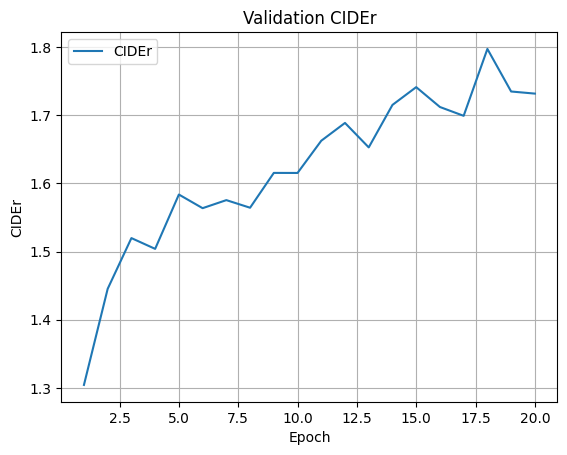

In [16]:
checkpoint = torch.load(save_path_xe, map_location=device, weights_only=False)
model.load_state_dict(checkpoint['model_state_dict'])
print(f"Loaded XE model from epoch {checkpoint['epoch']+1}, CIDEr: {checkpoint['cider']:.4f}")

# Lower learning rate for SCST
optimizer = torch.optim.AdamW([
    {'params': encoder.parameters(), 'lr': 5e-6},
    {'params': decoder.parameters(), 'lr': 1e-4}
], weight_decay=1e-4)

num_epochs_scst = 20
best_cider_scst = checkpoint['cider']  # ← Sửa typo: best_cider_sct -> best_cider_scst
save_path_scst = "captioner_rsicd_scst.pt"
epochs_no_improve = 0
ciders = []

for epoch in range(num_epochs_scst):
    # ← THÊM optimizer vào đây
    train_loss, avg_reward = train_one_epoch_scst(
        model, train_loader, tokenizer, optimizer, device
    )
    val_loss, bleu4, cider = evaluate(model, val_loader, tokenizer, device)
    ciders.append(cider)
    print(f"Epoch {epoch+1}/{num_epochs_scst}")
    print(f"  Train Loss: {train_loss:.4f}, Avg Reward: {avg_reward:.4f}")
    print(f"  Val Loss: {val_loss:.4f}, BLEU-4: {bleu4*100:.2f}, CIDEr: {cider:.4f}")

    if cider > best_cider_scst:
        best_cider_scst = cider
        torch.save({
            'epoch': epoch,
            'model_state_dict': model.state_dict(),
            'optimizer_state_dict': optimizer.state_dict(),
            'cider': cider,
            'bleu4': bleu4,
        }, save_path_scst)
        print(f"  Saved best SCST model (CIDEr: {cider:.4f})")
        epochs_no_improve = 0
    else:
        epochs_no_improve += 1
        if epochs_no_improve >= 5 and epoch>=14:  # Shorter patience for SCST
            print("Early stopping triggered")
            break

print("\n" + "="*70)
print("Training completed!")
print(f"Best XE CIDEr: {best_cider:.4f}")
print(f"Best SCST CIDEr: {best_cider_scst:.4f}")
print(f"Improvement: {(best_cider_scst - best_cider):.4f} (+{(best_cider_scst/best_cider - 1)*100:.1f}%)")
plot_cider_curve(ciders)

In [17]:
checkpoint = torch.load(save_path_scst, map_location=device, weights_only=False)
model.load_state_dict(checkpoint['model_state_dict'])
print(f"Loaded best SCST model from epoch {checkpoint['epoch']+1}")
print(f"  - Validation CIDEr: {checkpoint['cider']:.4f}")
print(f"  - Validation BLEU-4: {checkpoint['bleu4']*100:.2f}\n")

test_results, test_refs, test_hyps = test_evaluation(model, test_loader, tokenizer, device)

print("\n" + "="*70)
print("TEST RESULTS:")
print("="*70)
print(f"Number of test samples: {test_results['num_samples']}")
print(f"Loss: {test_results['loss']:.4f}\n")
print("Scores:")
print(f"  BLEU-1:  {test_results['BLEU_1']*100:6.2f}")
print(f"  BLEU-2:  {test_results['BLEU_2']*100:6.2f}")
print(f"  BLEU-3:  {test_results['BLEU_3']*100:6.2f}")
print(f"  BLEU-4:  {test_results['BLEU_4']*100:6.2f}")
print(f"  METEOR:  {test_results['METEOR']*100:6.2f}")
print(f"  ROUGE-L: {test_results['ROUGE_L']*100:6.2f}")
print(f"  CIDEr:   {test_results['CIDEr']:6.4f}")
if test_results['SPICE'] is not None:
    print(f"  SPICE:   {test_results['SPICE']*100:6.2f}")

Loaded best SCST model from epoch 18
  - Validation CIDEr: 1.7969
  - Validation BLEU-4: 42.59

Generating captions for test set...


Test: 100%|██████████| 18/18 [00:52<00:00,  2.94s/it]



Computing metrics...
  - Computing BLEU scores...
{'testlen': 11586, 'reflen': 11775, 'guess': [11586, 10493, 9400, 8307], 'correct': [7154, 3067, 1617, 880]}
ratio: 0.9839490445859037
  - Computing METEOR...
  - Computing ROUGE-L...
  - Computing CIDEr...
  - Computing SPICE...
Progress: 384.5M / 384.5M (100.0%)
Extracting stanford-corenlp-3.6.0 ...
Done.
  - SPICE not available: Command '['java', '-jar', '-Xmx8G', 'spice-1.0.jar', '/usr/local/lib/python3.12/dist-packages/pycocoevalcap/spice/tmp/tmpjo08do8y', '-cache', '/usr/local/lib/python3.12/dist-packages/pycocoevalcap/spice/cache', '-out', '/usr/local/lib/python3.12/dist-packages/pycocoevalcap/spice/tmp/tmp70ypounm', '-subset', '-silent']' returned non-zero exit status 1.

TEST RESULTS:
Number of test samples: 1093
Loss: 5.4079

Scores:
  BLEU-1:   60.75
  BLEU-2:   41.80
  BLEU-3:   30.92
  BLEU-4:   23.56
  METEOR:   26.53
  ROUGE-L:  44.48
  CIDEr:   0.5357



Visualizing random examples...

Saved visualization to 'test_predictions.png'


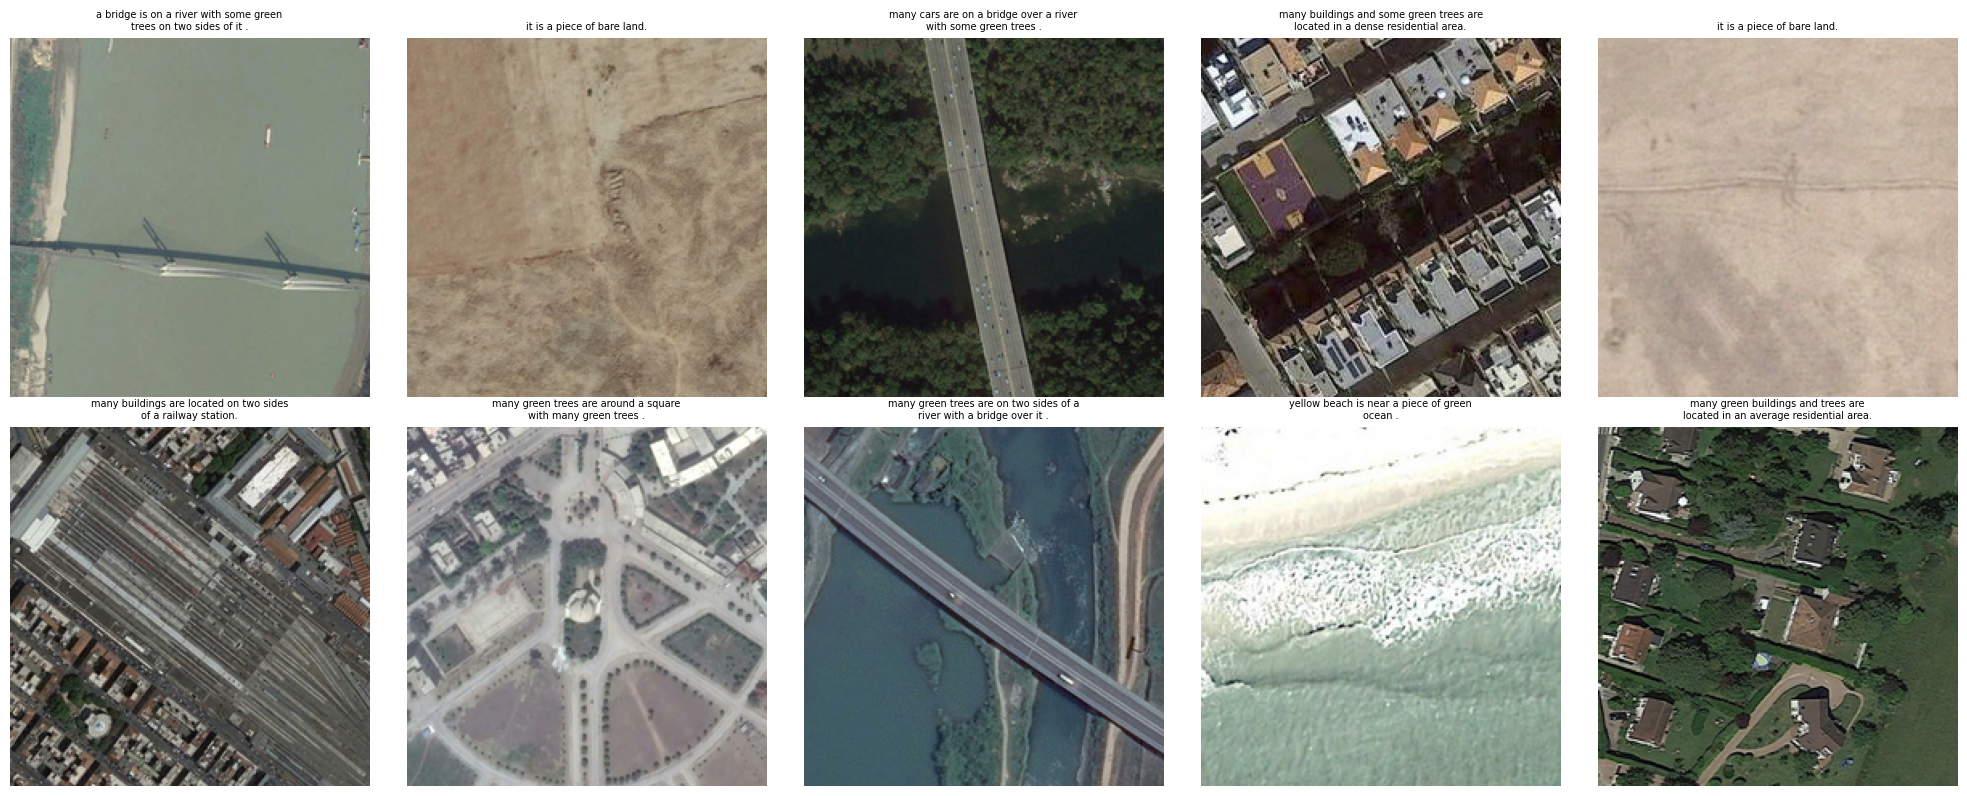

In [18]:
import matplotlib.pyplot as plt
import textwrap
import json

def visualize_predictions(refs, hyps, dataset, num_examples=10):
    indices = random.sample(range(len(refs)), min(num_examples, len(refs)))

    cols = 5
    rows = (num_examples + cols - 1) // cols

    fig, axes = plt.subplots(rows, cols, figsize=(4*cols, 4*rows))
    axes = axes.flatten() if num_examples > 1 else [axes]

    for ax_idx, img_idx in enumerate(indices):
        ex = dataset.data[img_idx]
        img_path = ex.get("image_path", ex.get("image"))
        if isinstance(img_path, str):
            image = Image.open(img_path).convert("RGB")
        else:
            image = ex["image"]
            if not isinstance(image, Image.Image):
                image = Image.fromarray(np.array(image))

        axes[ax_idx].imshow(image)
        axes[ax_idx].axis('off')

        pred = hyps[img_idx][0]
        wrapped_pred = textwrap.fill(pred, width=40)
        axes[ax_idx].set_title(wrapped_pred, fontsize=7)

    for ax_idx in range(num_examples, len(axes)):
        axes[ax_idx].axis('off')

    plt.tight_layout()
    plt.savefig('test_predictions.png', dpi=150, bbox_inches='tight')
    print("\nSaved visualization to 'test_predictions.png'")
    plt.show()

print("\nVisualizing random examples...")
visualize_predictions(test_refs, test_hyps, test_data, num_examples=10)


In [19]:
output_file = 'test_predictions.json'
predictions = []
for idx in range(len(test_refs)):
    predictions.append({
        'image_id': idx,
        'ground_truth': test_refs[idx],
        'prediction': test_hyps[idx][0]
    })

with open(output_file, 'w', encoding='utf-8') as f:
    json.dump({
        'metrics': {k: float(v) if v is not None else None for k, v in test_results.items()},
        'predictions': predictions[:100]
    }, f, indent=2, ensure_ascii=False)

print(f"\nSaved predictions to '{output_file}'")


Saved predictions to 'test_predictions.json'
